# Deep learning A-Z : Building a SOM

<p align="justify">
This notebook is my response to the fourth homework of the course called *Deep Learning A-Z™: Hands-On Artificial Neural Networks* accessible here : https://www.udemy.com/deeplearning/
</p>
<p align="justify">
In this notebook, we are going to build a Self Organizing Map (SOM) using minisom by following instructions given on the course. This will allow us to detect potential credit card fraud among customers who bought a credit card. We will use unsupervised learning to detect patterns (segments of customers) in data and one of those parttern will be the potential fraud.
</p>

### Imports

In [64]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from minisom import MiniSom
from pylab import bone, pcolor, colorbar, plot, show

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

### 1. Data preprocessing

The fraud detection will consist of identifiying outliers with a SOM. We will compute the mean of eclidian distance betweet a point and its neighborhood on the SOM. The points which will have the biggest MED will be the outliers (the potential fraudsters).

In [2]:
path_train = os.path.join(os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath('__file__')))), 'ressources/Self_Organizing_Maps/Credit_Card_Applications.csv')
dataset = pd.read_csv(path_train)
dataset.head()

,CustomerID,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,Class
0,15776156,1,22.08,11.46,2,4,4,1.585,0,0,0,1,2,100,1213,0
1,15739548,0,22.67,7.00,2,8,4,0.165,0,0,0,0,2,160,1,0
2,15662854,0,29.58,1.75,1,4,4,1.250,0,0,0,1,2,280,1,0
3,15687688,0,21.67,11.50,1,5,3,0.000,1,1,11,1,2,0,1,1
4,15715750,1,20.17,8.17,2,6,4,1.960,1,1,14,0,2,60,159,1


In [3]:
dataset.shape

(690, 16)

Last column contain informaton about if clients application was approuved of not. In this way, we will be able to compare, on the SOM, the customers who have approuval and those who do not have it (so we will be able to identify the customers who are fraudulent and who got their application approved).

In [4]:
# Attributes
X = dataset.iloc[:, :-1].values
# Class (approved of not)
y = dataset.iloc[:, -1].values

In [5]:
# Features scaling (normalization)
sc = MinMaxScaler(feature_range=(0,1))
X = sc.fit_transform(X)
X

array([[8.42681467e-01, 1.00000000e+00, 1.25263158e-01, ...,
        5.00000000e-01, 5.00000000e-02, 1.21200000e-02],
       [6.96090562e-01, 0.00000000e+00, 1.34135338e-01, ...,
        5.00000000e-01, 8.00000000e-02, 0.00000000e+00],
       [3.88981656e-01, 0.00000000e+00, 2.38045113e-01, ...,
        5.00000000e-01, 1.40000000e-01, 0.00000000e+00],
       ...,
       [4.39420332e-01, 0.00000000e+00, 7.63909774e-02, ...,
        5.00000000e-01, 5.00000000e-02, 0.00000000e+00],
       [8.44034934e-01, 0.00000000e+00, 2.05563910e-01, ...,
        5.00000000e-01, 6.00000000e-02, 1.10000000e-04],
       [1.06907888e-01, 1.00000000e+00, 4.09774436e-01, ...,
        0.00000000e+00, 2.80000000e-01, 0.00000000e+00]])

### 2. Building the SOM

In [10]:
# initializing som
som = MiniSom(x=10, y=10, input_len=15)

- *x, y* is the size of the grid for the SOM
- *input_len* is the number of features in our dataset
- *learning rate* higher lr means quicker convergence

In [11]:
som.random_weights_init(X) # initializing weights randomly close to 0
som.train_random(data=X, num_iteration=100) # We don't train on X and y, just on X because it's unsueprvised learning

### 3. Plot the SOM

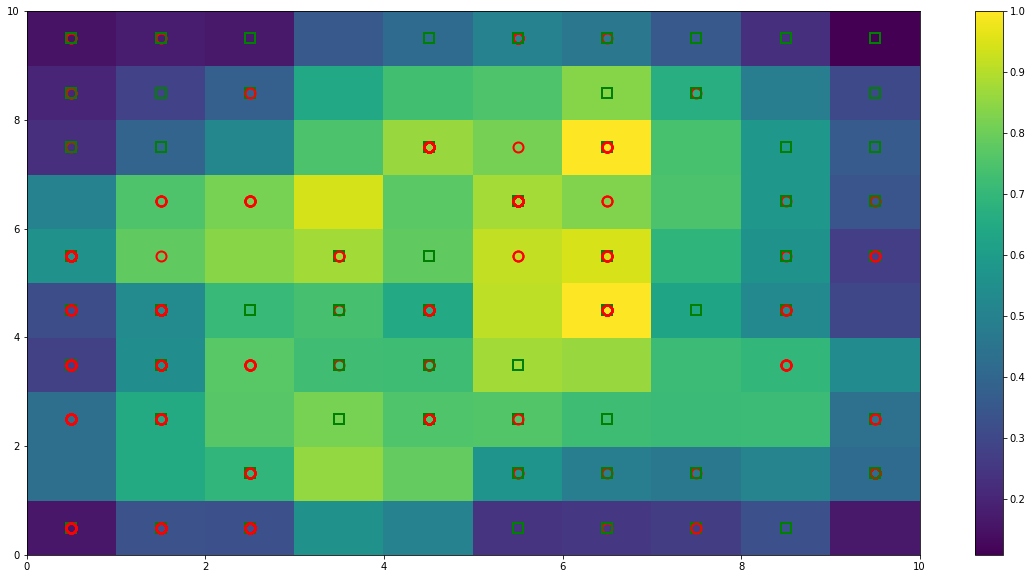

In [12]:
plt.figure(figsize=(20,10))
pcolor(som.distance_map().T) # distance_map method will return all the mean distances for winning nodes in one matrix
colorbar()

# add red circles and green squares for customer who did not get approval and customer who got approval respectively
markers = ['o', 's']
colors = ['r', 'g']

for i, x in enumerate(X):
    w = som.winner(x) # get coordinate of winning node for observation x
    plot(w[0] + 0.5, 
         w[1] + 0.5, # plot marker AT THE MIDDLE of the square representing the winning node
         markers[y[i]],
         markeredgecolor=colors[y[i]],
         markerfacecolor='None',
         markersize=10, # graphical settings
         markeredgewidth=2) 

show()

We can clearly see that, on the white squared representing the outliers (so the potential frauds), there are customers which received an approval and customers which did not received the approval. Now, we have to catch the cheaters, in priority the ones who get approvals.

### 4. Finding the frauds

In [13]:
mapping = som.win_map(X) # dict containing the observations pet node of the SOM
#frauds = mapping[2, 4] # get customers in white winning node of SOM above
frauds = np.concatenate((mapping[6, 4], mapping[6, 7]), axis=0) # to concatenate 2 nodes

In [14]:
frauds = sc.inverse_transform(frauds)
frauds = pd.DataFrame(frauds, columns=dataset.columns.tolist()[:-1])
frauds.head()

,CustomerID,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14
0,15687688.0,0.0,21.67,11.50,1.0,5.0,3.0,0.000,1.0,1.0,11.0,1.0,2.0,0.0,1.0
1,15668679.0,0.0,47.42,3.00,2.0,14.0,4.0,13.875,1.0,1.0,2.0,1.0,2.0,519.0,1705.0
2,15738487.0,0.0,20.75,10.25,2.0,11.0,4.0,0.710,1.0,1.0,2.0,1.0,2.0,49.0,1.0
3,15594305.0,0.0,23.75,0.71,2.0,9.0,4.0,0.250,0.0,1.0,1.0,1.0,2.0,240.0,5.0
4,15664793.0,0.0,17.33,9.50,2.0,6.0,4.0,1.750,0.0,1.0,10.0,1.0,2.0,0.0,11.0


In [15]:
frauds.shape

(47, 15)

Finally, we have the list of potential frauds !

### 5. Homework - Mega case study : combining ANN and SOM to get probability of frauds

I this part, we are going to combine supervised and unsupervides learning by building an ann which will take as input data output from SOM and will try to predict probability of frauds for each observation. Let's begin by creating a new dataframe with a new column 'fraud' which contains 1 for fraud predicted by the SOM and 0 for other.

In [31]:
df = dataset.copy()
df['Fraud'] = d.apply(lambda row: 1 if row.CustomerID in frauds['CustomerID'].astype(int).tolist() else 0, axis=1)
df.head()

,CustomerID,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,Class,Fraud
0,15776156,1,22.08,11.46,2,4,4,1.585,0,0,0,1,2,100,1213,0,0
1,15739548,0,22.67,7.00,2,8,4,0.165,0,0,0,0,2,160,1,0,0
2,15662854,0,29.58,1.75,1,4,4,1.250,0,0,0,1,2,280,1,0,0
3,15687688,0,21.67,11.50,1,5,3,0.000,1,1,11,1,2,0,1,1,1
4,15715750,1,20.17,8.17,2,6,4,1.960,1,1,14,0,2,60,159,1,0


In [45]:
df['Fraud'].value_counts()

0    643
1     47
Name: Fraud, dtype: int64

From there, let's use an ann to predict the probability of Fraud for each CustomerID using an ANN.

In [56]:
X2 = df.iloc[:, 1:16].values
y2 = df.iloc[:, 16].values

In [61]:
# Feature Scaling
sc = StandardScaler()
X2 = sc.fit_transform(X2)
X2

array([[ 0.68873723, -0.80105183,  1.34711063, ..., -0.48835847,
         0.03738039, -0.89530251],
       [-1.45193254, -0.75124044,  0.45054795, ..., -0.13959116,
        -0.19541334, -0.89530251],
       [-1.45193254, -0.16785619, -0.60482292, ...,  0.55794344,
        -0.19541334, -0.89530251],
       ...,
       [-1.45193254, -1.07543661,  0.96114643, ..., -0.48835847,
        -0.19541334,  1.11694091],
       [-1.45193254, -0.35021653,  1.95822062, ..., -0.3721027 ,
        -0.19330052,  1.11694091],
       [ 0.68873723,  0.79628971, -0.94857229, ...,  2.18552419,
        -0.19541334,  1.11694091]])

In [67]:
classifier = Sequential()
classifier.add(Dense(units=8, kernel_initializer='uniform', activation='relu', input_shape = (15,)))
classifier.add(Dropout(p=0.1)) 
classifier.add(Dense(units=8, kernel_initializer='uniform', activation='relu'))
classifier.add(Dropout(p=0.1))
classifier.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [68]:
classifier.fit(X2, y2, batch_size=10, epochs=100)

Epoch 1/100
690/690 [==============================] - 1s 1ms/step - loss: 0.6714 - acc: 0.9261
Epoch 2/100
690/690 [==============================] - 0s 219us/step - loss: 0.5410 - acc: 0.9319
Epoch 3/100
690/690 [==============================] - 0s 270us/step - loss: 0.3059 - acc: 0.9319
Epoch 4/100
690/690 [==============================] - 0s 286us/step - loss: 0.2068 - acc: 0.9319
Epoch 5/100
690/690 [==============================] - 0s 272us/step - loss: 0.1761 - acc: 0.9319
Epoch 6/100
690/690 [==============================] - 0s 261us/step - loss: 0.1668 - acc: 0.9319
Epoch 7/100
690/690 [==============================] - 0s 333us/step - loss: 0.1526 - acc: 0.9319
Epoch 8/100
690/690 [==============================] - 0s 271us/step - loss: 0.1434 - acc: 0.9319
Epoch 9/100
690/690 [==============================] - 0s 276us/step - loss: 0.1323 - acc: 0.9319
Epoch 10/100
690/690 [==============================] - 0s 303us/step - loss: 0.1220 - acc: 0.9319
Epoch 11/100
690/690 

In [70]:
fraud_probability = classifier.predict(X2)
df['Fraud_proba'] = fraud_probability
df.head()

,CustomerID,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,Class,Fraud,Fraud_proba
0,15776156,1,22.08,11.46,2,4,4,1.585,0,0,0,1,2,100,1213,0,0,1.891988e-20
1,15739548,0,22.67,7.00,2,8,4,0.165,0,0,0,0,2,160,1,0,0,1.248447e-07
2,15662854,0,29.58,1.75,1,4,4,1.250,0,0,0,1,2,280,1,0,0,7.574251e-06
3,15687688,0,21.67,11.50,1,5,3,0.000,1,1,11,1,2,0,1,1,1,8.541015e-01
4,15715750,1,20.17,8.17,2,6,4,1.960,1,1,14,0,2,60,159,1,0,4.124840e-21


In [79]:
df = df[['CustomerID', 'Fraud_proba']]
df.head()

,CustomerID,Fraud_proba
0,15776156,1.891988e-20
1,15739548,1.248447e-07
2,15662854,7.574251e-06
3,15687688,8.541015e-01
4,15715750,4.124840e-21


Finally, here are the customer which have the highest probability of fraud :

In [87]:
result = df.sort_values('Fraud_proba', axis=0, ascending= False)
result.head(50)

,CustomerID,Fraud_proba
345,15720725,0.854101
513,15631267,0.854101
174,15636521,0.854101
457,15598614,0.854101
171,15621244,0.854101
167,15699238,0.854101
483,15750104,0.854101
497,15608804,0.854101
291,15793825,0.854101
39,15668679,0.854101


### 6. Homework Solution

Basically, the code of the solution is doing exactly the same thing as i've done above 🎉🎉🎉 :

In [ ]:
# Creating the matrix of features
customers = dataset.iloc[:, 1:].values
# Creating the dependent variable
is_fraud = np.zeros(len(dataset))
for i in range(len(dataset)):
    if dataset.iloc[i,0] in frauds:
        is_fraud[i] = 1
        
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
customers = sc.fit_transform(customers)

# Initialising the ANN
classifier = Sequential()
# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 2, kernel_initializer = 'uniform', activation = 'relu', input_dim = 15))
# Adding the output layer
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
# Fitting the ANN to the Training set
classifier.fit(customers, is_fraud, batch_size = 1, epochs = 2)

# Predicting the probabilities of frauds
y_pred = classifier.predict(customers)
y_pred = np.concatenate((dataset.iloc[:, 0:1].values, y_pred), axis = 1)
y_pred = y_pred[y_pred[:, 1].argsort()]